In [1]:
"""
Importing required libraries
"""
import sys
import sklearn
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import mixture
from sklearn.decomposition import FastICA, PCA
from sklearn import random_projection
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_samples
from sklearn.mixture import BayesianGaussianMixture
from sklearn.model_selection import train_test_split
from matplotlib.ticker import FixedLocator, FixedFormatter
from sklearn.metrics import adjusted_mutual_info_score,mutual_info_score,adjusted_rand_score,homogeneity_completeness_v_measure
from time import time
from scipy.io.arff import loadarff 
import numpy as np
import itertools
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection, neighbors)
from sklearn.mixture import GaussianMixture
import os
from matplotlib.colors import LogNorm
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
random_state = np.random.RandomState(17)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Dataset 
Refrence:
- https://archive.ics.uci.edu/ml/datasets/Diabetic+Retinopathy+Debrecen+Data+Set

## Dataset Attribute Information:
Dataset name: Messidor (Diabetic Retinopathy Debrecen)
following description of fetures are obtainbed from: https://archive.ics.uci.edu/ml/datasets/Diabetic+Retinopathy+Debrecen+Data+Set

- 0) quality of image (Binart 0:Bad 1: acceptable)
- 1) pre-screening indication of disease 0: no sign 1: disease is present
- 2-7) " The results of MA detection. Each feature value stand for the
        number of MAs found at the confidence levels alpha = 0.5, . . . , 1, respectively".
- 8-15) similar to (2-7) for exudates. see refrence for more information.
- 16) The euclidean distance feture of patients retina
- 17) optic disc diameter.
- 18) AM/FM based class (binary).
- 19) 1 = contains signs disease, 0 = no signs

In [2]:
messidor_data_path = os.path.join("Data", "messidor_features.arff")
messidor_data = loadarff(messidor_data_path)
messidor = pd.DataFrame(messidor_data[0])
messidor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1151 entries, 0 to 1150
Data columns (total 20 columns):
0        1151 non-null float64
1        1151 non-null float64
2        1151 non-null float64
3        1151 non-null float64
4        1151 non-null float64
5        1151 non-null float64
6        1151 non-null float64
7        1151 non-null float64
8        1151 non-null float64
9        1151 non-null float64
10       1151 non-null float64
11       1151 non-null float64
12       1151 non-null float64
13       1151 non-null float64
14       1151 non-null float64
15       1151 non-null float64
16       1151 non-null float64
17       1151 non-null float64
18       1151 non-null float64
Class    1151 non-null object
dtypes: float64(19), object(1)
memory usage: 180.0+ KB


In [3]:
messidor["Class"].value_counts()

b'1'    611
b'0'    540
Name: Class, dtype: int64

## Load/Split/Process Data:

In [4]:
from sklearn.model_selection import train_test_split

messidor_train_set, messidor_test_set = train_test_split(messidor, test_size=0.2, random_state=17)
# Separate predictors and labels for messidor data
messidor_train_features = messidor_train_set.drop("Class",axis=1)
messidor_train_labels = messidor_train_set["Class"].copy()
# identifying the categorical and numerical data for messidor data
messidor_cat_attrs = ['0','1','18']
messidor_num_attrs = [c for c in messidor_train_features.columns if c not in messidor_cat_attrs ]
messidor_train_labels.value_counts()

# preprocessing the messidor data
pipeline = ColumnTransformer([
        ("num", StandardScaler(), messidor_num_attrs),
        ("cat", OneHotEncoder(), messidor_cat_attrs),
    ])
    
X = pipeline.fit_transform(messidor_train_features)
ordinal_encoder = LabelEncoder()
y = ordinal_encoder.fit_transform(messidor_train_labels)
# messidor test set preprocessing
messidor_test_features = messidor_test_set.drop("Class",axis=1)
messidor_test_prep = pipeline.transform(messidor_test_features)
messidor_test_labels = messidor_test_set["Class"].copy()
messidor_test_labels_prep = ordinal_encoder.transform(messidor_test_labels)

In [5]:
def plot_clusters(X, y=None,s=4):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=s)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

def plot_data(X,y_true=None):
    plt.scatter(X[:, 0], X[:, 1], c=y_true,s=3)
def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X,y_true=None, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X,y_true)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
        plt.tick_params(labelleft=False)

Saving figure messidor_plot


<Figure size 800x400 with 0 Axes>

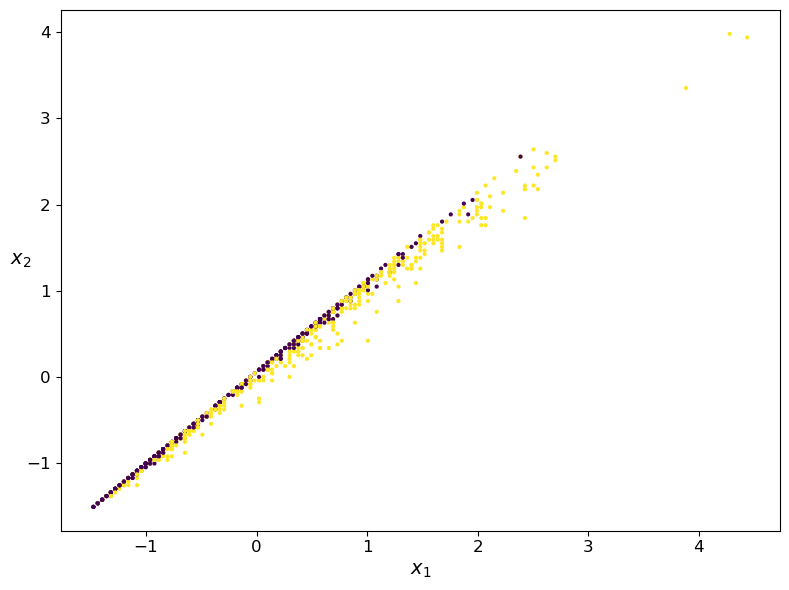

In [6]:
plt.figure(figsize=(8, 4))
plot_clusters(X,y)
save_fig("messidor_plot")
plt.show()

# Dimensionality Reduction (DR)

## LLE:
Locally linear embedding (LLE) seeks a lower-dimensional projection of the data which preserves distances within local neighborhoods. It can be thought of as a series of local Principal Component Analyses which are globally compared to find the best non-linear embedding.([Link](https://scikit-learn.org/stable/modules/manifold.html#locally-linear-embedding))

## Optimum LLE dimensions

In [7]:
lle = LocallyLinearEmbedding(n_components=21, n_neighbors=50, random_state=0)
X_reduced = lle.fit_transform(X)

In [8]:
X_reduced.shape

(920, 21)

In [9]:
lle.reconstruction_error_

0.04284181373232262

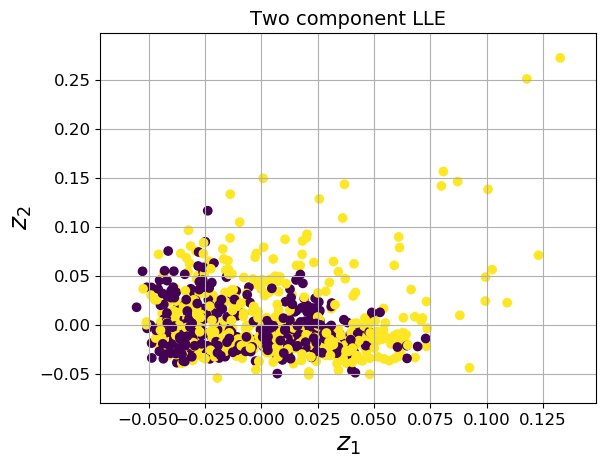

In [10]:
plt.title("Two component LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y)#, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.grid(True)

# save_fig("lle_unrolling_plot")
plt.show()

### Reconstruction Error

In [11]:
from sklearn.metrics import mean_squared_error
error =[]
for nn in [22,40,50]:
    temp=[]
    for rand in range(10):
        lle_per_comp = [LocallyLinearEmbedding(n_components=k, n_neighbors=nn,method='modified', random_state=0).fit(X) 
                        for k in range(1,X.shape[1]+1)]
        temp_errors = [lle.reconstruction_error_ for lle in lle_per_comp]
        temp.append(temp_errors)
    error.append(temp)

In [12]:
errors = [np.mean(np.array(err),axis=0) for err in error] 

LLE modified method require the number of neighbors to be more than the n_component and since max dimension is 26, 27 was selected for the number of neighbors

Saving figure LLE_messidor_reconstruct_error_plot


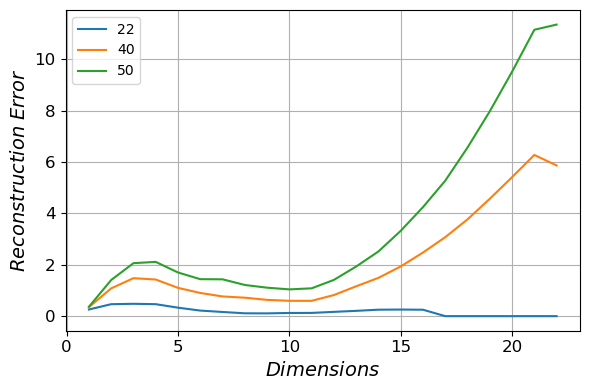

17

In [13]:
plt.figure(figsize=(6,4))
num_n = [22,40,50]
for er,label in zip(errors,num_n):
    plt.plot(np.arange(1,X.shape[1]+1),er,label = label)
min_point = np.argmin(errors)
# plt.axis([0,X.shape[1]+1, 0, np.min(errors)+1])
d = min_point+1
# plt.plot([d, d], [0,np.max(kurtosis_per_comp)+1], "k:")
plt.xlabel("$Dimensions$")
plt.ylabel("$Reconstruction$ $Error$")
plt.grid(True)
plt.legend()
save_fig("LLE_messidor_reconstruct_error_plot")
plt.show()

d

In [14]:
lle = LocallyLinearEmbedding(n_components=8, n_neighbors=22,method='modified', random_state=0)
X_reduced = lle.fit_transform(X)

# Clustering: 

In [15]:
X_DR = X_reduced.copy()

## 1- _K-Means_

### Optimum Number of Clusters

### Elbow Method:

In [16]:
kmeans_with_var_k = [KMeans(n_clusters=k, random_state=9).fit(X_DR) for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_with_var_k]

Saving figure LLE_messidor_inertia_vs_k_plot


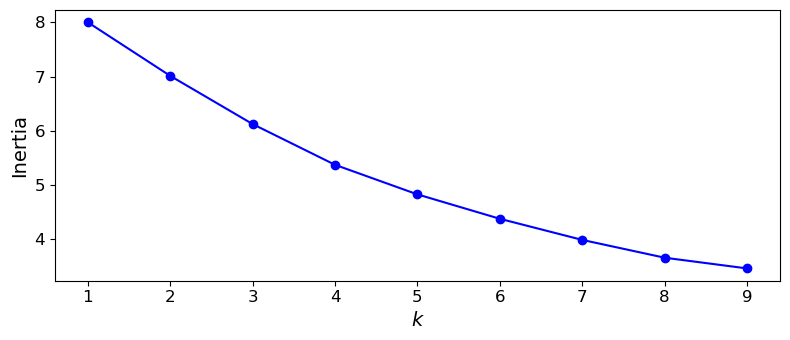

In [17]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
save_fig("LLE_messidor_inertia_vs_k_plot")
plt.show()

### Silhouette score :

In [18]:
silhouette_scores = [silhouette_score(X_DR, model.labels_) for model in kmeans_with_var_k[1:]]

Saving figure LLE_messidor_silhouette_score_vs_k_plot


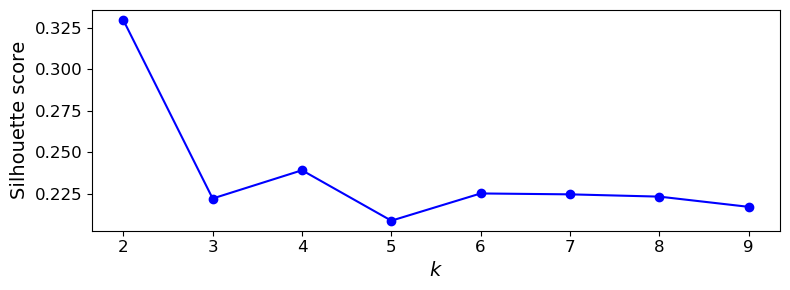

In [19]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
# plt.axis([1.8, 8.5, 0.55, 0.7])
save_fig("LLE_messidor_silhouette_score_vs_k_plot")
plt.show()

Based on the result there is not clear Elbow in inertia plot (maybe k=3) but the silhouette score for k=2 will result in the max score based on these result I consider k=2 as the optimum number of clusters

Saving figure LLE_messidor_silhouette_analysis_plot


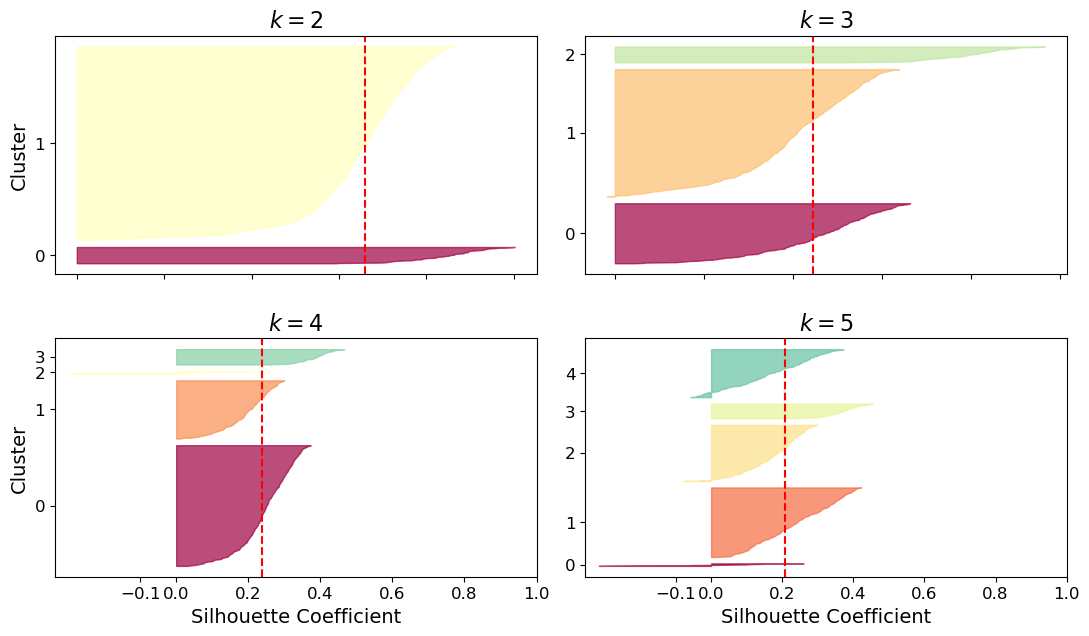

In [20]:
plt.figure(figsize=(11, 9))

for k in (2, 3, 4, 5):
    plt.subplot(3, 2, k - 1)
    
    y_pred = kmeans_with_var_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X_DR, y_pred)

    padding = len(X_DR) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (2, 4):
        plt.ylabel("Cluster")
    
    if k in (4, 5):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

save_fig("LLE_messidor_silhouette_analysis_plot")
plt.show()

Based on the silhouette diagram it appears k=2 and k=3 will result in better clusterrs. based on this we use k=3 since it results in most of the clustes having similar sized while its score is slightly less than the k=3


In [21]:
# Model with optimnal k value
kmeans_optimum = kmeans_with_var_k[2]
y_pred = kmeans_optimum.fit_predict(X_DR)
# kmeans_optimum.cluster_centers_

### Evaluation

In [22]:
# adjusted_mutual_info_score
from sklearn.metrics import adjusted_mutual_info_score,mutual_info_score,adjusted_rand_score,homogeneity_completeness_v_measure
adjusted_mutual_info_score(y,y_pred)

0.0042014391897814566

In [23]:
# adjusted Rand index
adjusted_rand_score(y,y_pred)

-0.00012805323657353885

In [24]:
# Homogeneity, completeness and V-measure
# homogeneity
# completeness
# V-measure
homogeneity_completeness_v_measure(y,y_pred)

(0.006271666571734527, 0.005076034031226071, 0.005610862334933591)

Computing t-SNE embedding


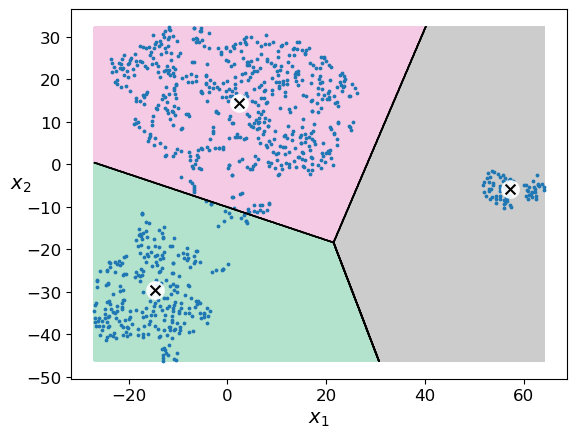

In [25]:
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection, neighbors)

tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(X_DR)
kmeans = KMeans(n_clusters=3, random_state=9)
kmeans.fit(X_tsne)
y_pred_tsne = kmeans.fit_predict(X_tsne)
plot_decision_boundaries(kmeans,X_tsne)


In [26]:
pca_viz = PCA(n_components=2)
pca_viz.fit(X_DR)
X_DR_pca_viz = pca_viz.fit_transform(X_DR)

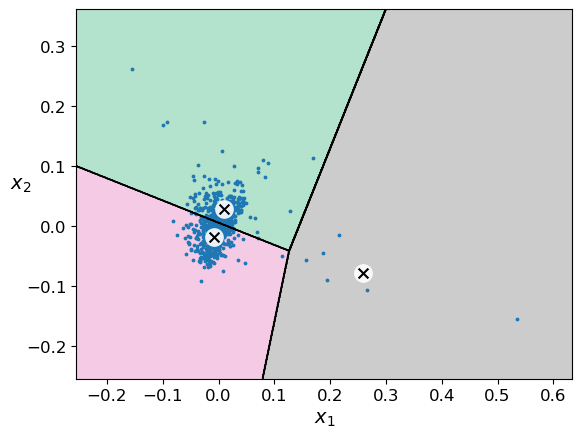

In [27]:
kmeans_pca_viz = KMeans(n_clusters=3, random_state=9)
kmeans_pca_viz.fit(X_DR_pca_viz)
plot_decision_boundaries(kmeans_pca_viz,X_DR_pca_viz)


Saving figure LLE_messidor_K_means_cluster_TsnE


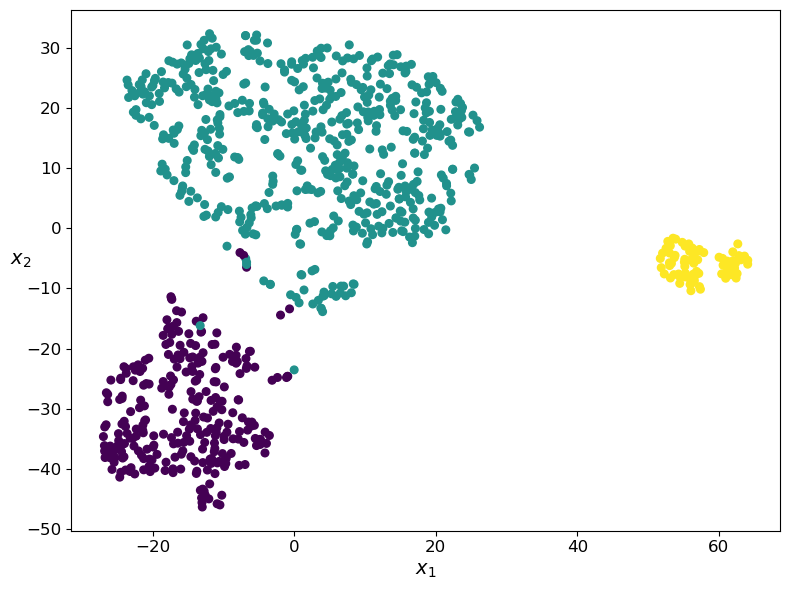

In [28]:
plot_clusters(X_tsne,y_pred,s=30)
save_fig("LLE_messidor_K_means_cluster_TsnE")

Saving figure LLE_messidor_K_means_cluster_PCA


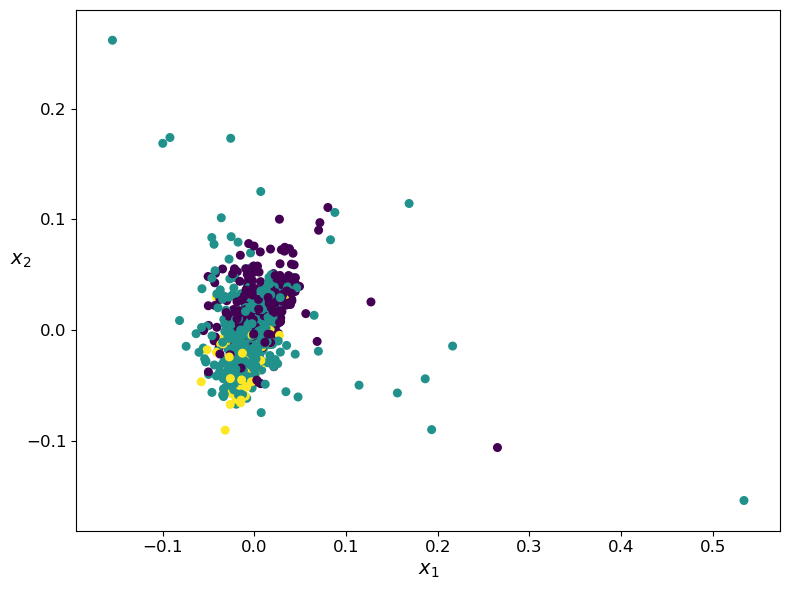

In [29]:
plot_clusters(X_DR_pca_viz,y_pred,s=30)
save_fig("LLE_messidor_K_means_cluster_PCA")

# 2- _Gaussian Mixture (EM)_

In [30]:
from sklearn.mixture import GaussianMixture
g_mix = GaussianMixture(n_components=3, n_init=10, random_state=42)
g_mix.fit(X_DR)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=10,
                precisions_init=None, random_state=42, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

## Optimum Number of Clusters

In [31]:
g_mix_with_var_k = [GaussianMixture(n_components=k, n_init=10, random_state=9).fit(X_DR) for k in range(1, 11)]

In [32]:
# calculating the Bayesian Information Criterion (BIC) and Akaike Information Criterion (AIC) for various k values.
bic_per_k = [model.bic(X_DR) for model in g_mix_with_var_k]
aics_per_k = [model.aic(X_DR) for model in g_mix_with_var_k]

Saving figure LLE_messidor_aic_bic_vs_k_plot


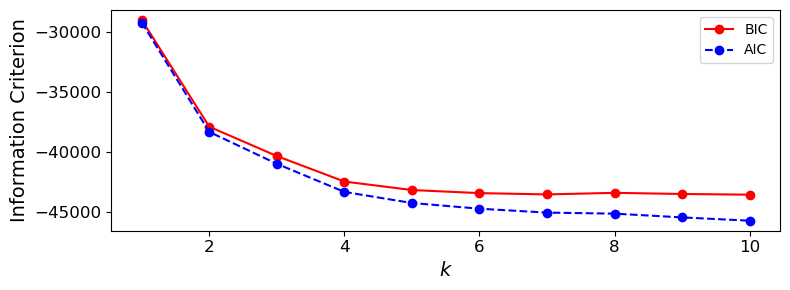

In [33]:
# Code Reference: https://colab.research.google.com/github/ageron/handson-ml2/blob/master/09_unsupervised_learning.ipynb
plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bic_per_k, "ro-", label="BIC")
plt.plot(range(1, 11), aics_per_k, "bo--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)

plt.legend()
save_fig("LLE_messidor_aic_bic_vs_k_plot")
plt.show()

Based on the above plot BIC is min at k=6 while AIC is min at k=9

In [34]:
bic_per_k[5],aics_per_k[8]

(-43451.046208975706, -45472.544018264714)

In [35]:
min_bic = np.infty
cov_type = ["full", "tied", "spherical", "diag"]
bic_lst = {"full":[], "tied":[], "spherical":[], "diag":[]}
for k in range(1, 11):
    temp=[]
    for covariance_type in cov_type:
        gm = GaussianMixture(n_components=k, n_init=10,
                              covariance_type=covariance_type,
                              random_state=9).fit(X_DR)
        bic = gm.bic(X_DR)
        if bic < min_bic:
            min_bic = bic
            best_k = k
            best_covariance_type = covariance_type
            best_gm=gm
        bic_lst[covariance_type].append(bic)

best_k,best_covariance_type

(10, 'full')

In [36]:
def bar_plot(ax, data, colors=None, total_width=0.8, single_width=1, legend=True):
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    n_bars = len(data)

    bar_width = total_width / n_bars

    bars = []

    for i, (name, values) in enumerate(data.items()):
  
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2

        for x, y in enumerate(values):
            bar = ax.bar(x + x_offset, y, width=bar_width * single_width, color=colors[i % len(colors)])

        bars.append(bar[0])

    # Draw legend if we need
    if legend:
        ax.legend(bars, data.keys())

Saving figure LLE_messidor_bic_vs_k


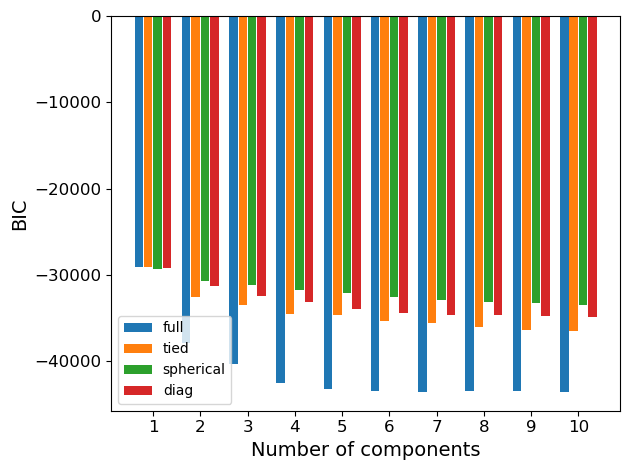

In [37]:
fig, ax = plt.subplots()
n_comp=np.arange(1, 11)
ax.set_xticks(np.arange(len(bic_lst['full'])))
ax.set_xticklabels(n_comp)
bar_plot(ax, bic_lst, total_width=.8, single_width=.9)

plt.xlabel('Number of components')
plt.ylabel('BIC')
save_fig("LLE_messidor_bic_vs_k")
plt.show()

Saving figure LLE_messidor_aic_bic_vs_k_plot_optimum


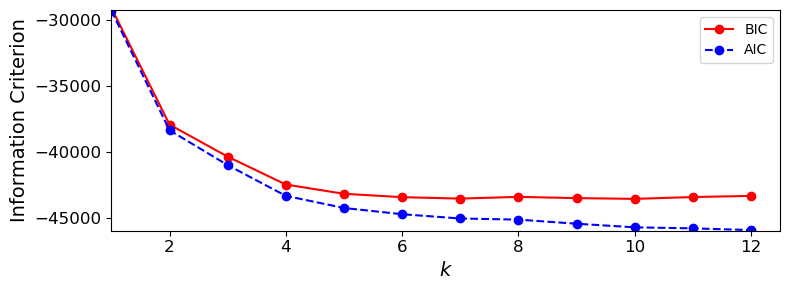

In [38]:
g_mix_with_var_k = [GaussianMixture(n_components=k, n_init=10,covariance_type=best_covariance_type, random_state=9).fit(X_DR) for k in range(1, 13)]
# calculating the Bayesian Information Criterion (BIC) and Akaike Information Criterion (AIC) for various k values.
bic_per_k = [model.bic(X_DR) for model in g_mix_with_var_k]
aics_per_k = [model.aic(X_DR) for model in g_mix_with_var_k]
plt.figure(figsize=(8, 3))
plt.plot(range(1, 13), bic_per_k, "ro-", label="BIC")
plt.plot(range(1, 13), aics_per_k, "bo--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 12.5, np.min(aics_per_k) - 50, np.max(aics_per_k) + 50])

plt.legend()
save_fig("LLE_messidor_aic_bic_vs_k_plot_optimum")
plt.show()

It seems the minimium for BIC is at k=10 while for AIC the k=12 result to a slighltly lower value it is reasonable to go with the k=10

In [39]:
bgm = BayesianGaussianMixture(n_components=20, n_init=10, random_state=9)
bgm.fit(X_DR)
np.round(bgm.weights_, 2)

array([0.47, 0.01, 0.01, 0.02, 0.  , 0.25, 0.02, 0.03, 0.03, 0.1 , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.01, 0.01, 0.03, 0.01, 0.  ])

## Optimum Model

In [40]:
gm_optimum = GaussianMixture(n_components=best_k, n_init=10, covariance_type= best_covariance_type,random_state=9).fit(X_DR)
y_pred_gm = gm_optimum.predict(X_DR)

## Evaluation

In [41]:
# adjusted_mutual_info_score
adjusted_mutual_info_score(y,y_pred_gm)

0.04570196046028143

In [42]:
# adjusted Rand index
adjusted_rand_score(y,y_pred_gm)

0.018511753926909017

In [43]:
# Homogeneity, completeness and V-measure
homogeneity_completeness_v_measure(y,y_pred_gm)

(0.0936336191763947, 0.03362236535412182, 0.049477967814118826)

In [44]:
def plot_gaussian_mixture(clusterer, X,y_true = None, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    fig, ax = plt.subplots()
    ax.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    ax.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    # plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    

    scatter = ax.scatter(X[:, 0], X[:, 1],c=y_true if y_true is not None else 'k'
     ,s=4)

    # produce a legend with the unique colors from the scatter
    if y_true is not None:
        legend1 = ax.legend(*scatter.legend_elements(),
                        loc="lower left", title="Classes")
        ax.add_artist(legend1)
    # plt.scatter(X[:, 0], X[:, 1],c=y,s=)

    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

Saving figure LLE_messidor_gaussian_mixtures


<Figure size 500x400 with 0 Axes>

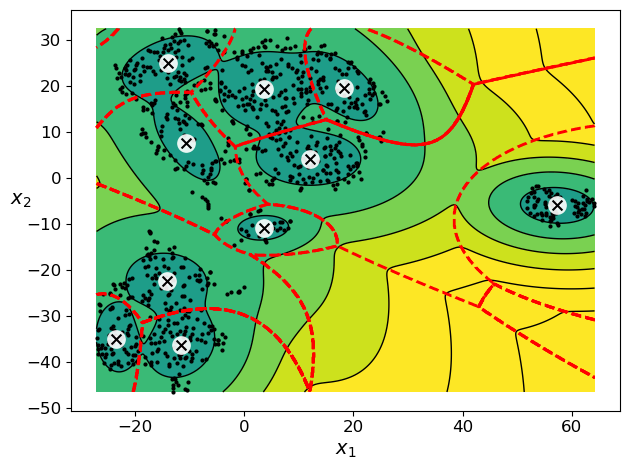

In [45]:
plt.figure(figsize=(5, 4))
gm_viz = GaussianMixture(n_components=best_k, n_init=10, covariance_type= best_covariance_type,random_state=9).fit(X_tsne)
plot_gaussian_mixture(gm_viz, X_tsne)

save_fig("LLE_messidor_gaussian_mixtures")
plt.show()

Saving figure LLE_messidor_gaussian_mixtures_cluster_TsnE


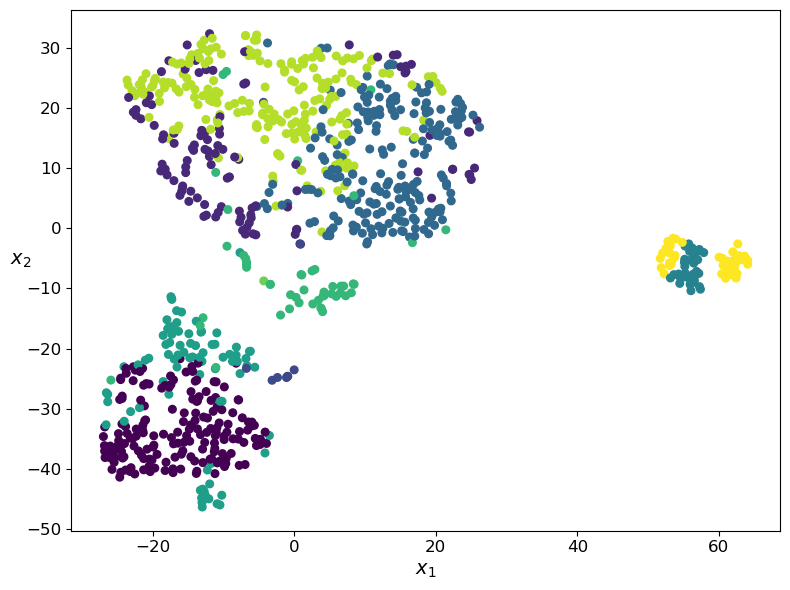

In [46]:
plot_clusters(X_tsne,y_pred_gm,30)
save_fig("LLE_messidor_gaussian_mixtures_cluster_TsnE")

Saving figure LLE_messidor_gaussian_mixtures_cluster_PCA


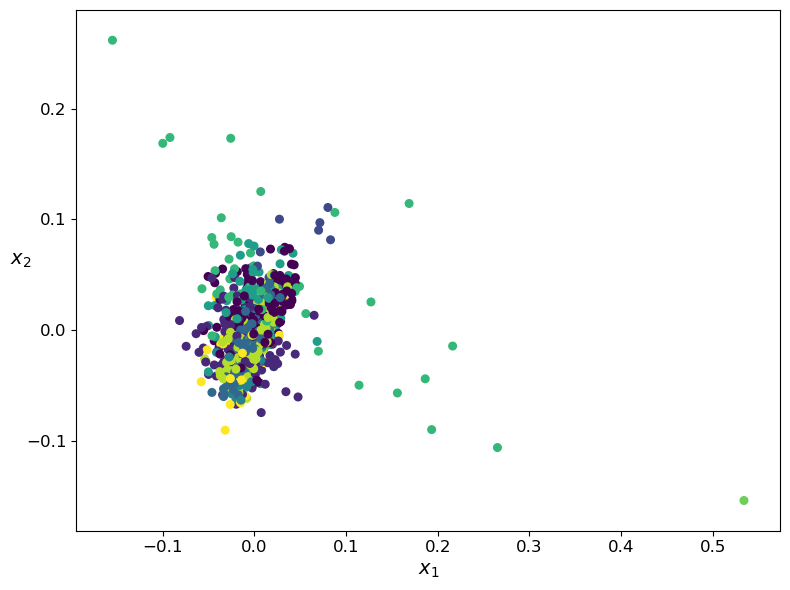

In [47]:
plot_clusters(X_DR_pca_viz,y_pred_gm,30)
save_fig("LLE_messidor_gaussian_mixtures_cluster_PCA")